### + random transforms
### + thread-safe gens

In [1]:
RUN = 'D'
RND = 777

In [31]:
IMAGES_DIR = '/d2/caches/kaggle-planet/processed-images-64x64'
IMAGE_SHAPE = (64, 64, 4)

TRAIN_BATCH_SIZE = 53
TRAIN_EPOCHS = 100

VAL_SPLIT = 0.2

VAL_BATCH_SIZE = 16

TENSORBOARD_DIR = '/tensorboard/planet/' + RUN
MODEL_CHECKPOINT_DIR = '/d2/caches/kaggle-planet/models/' + RUN

In [3]:
%run 'Lib.ipynb'

MODEL_CHECKPOINT_DIR not defined 


Using TensorFlow backend.


In [4]:
import keras
from keras.layers import *
from keras.applications import *
from keras.models import *
from keras.callbacks import *

In [5]:
# load data
X_files = np.load('out/X_files.npy')
Y_tags_misc = np.load('out/Y_tags_misc.npy')
Y_tags_weather = np.load('out/Y_tags_weather.npy')

In [6]:
# split data into tran/val sets
from sklearn.model_selection import train_test_split

X_files_train, X_files_val, \
Y_tags_misc_train, Y_tags_misc_val, \
Y_tags_weather_train, Y_tags_weather_val = \
train_test_split(
    X_files,
    Y_tags_misc,
    Y_tags_weather,
    test_size=VAL_SPLIT,
    random_state=RND)

In [7]:
# calculate samples per epoch so that epoch can consist of integer number of batches
TRAIN_SAMPLES_PER_EPOCH = int(len(X_files_train) / TRAIN_BATCH_SIZE) * TRAIN_BATCH_SIZE
print ('Samples per epoch (train):', TRAIN_SAMPLES_PER_EPOCH, 'of', len(X_files_train))

Samples per epoch (train): 32383 of 32383


In [8]:
# calculate samples per epoch so that epoch can consist of integer number of batches
VAL_SAMPLES_PER_EPOCH = int(len(X_files_val) / VAL_BATCH_SIZE) * VAL_BATCH_SIZE
print ('Samples per epoch (val):', VAL_SAMPLES_PER_EPOCH, 'of', len(X_files_val))

Samples per epoch (val): 8096 of 8096


In [9]:
# define model
image_input = Input(shape=IMAGE_SHAPE, name='image_input')

x = Conv2D(32, (3, 3), padding='same')(image_input)
x = Conv2D(32, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Flatten()(x)
features = Dropout(rate=0.5)(x)

out_tags_misc = Dense(Y_tags_misc.shape[1], activation='sigmoid', name='tags_misc')(features)
out_tags_weather = Dense(Y_tags_weather.shape[1], activation='softmax', name='tags_weather')(features)

model = Model(inputs=[image_input], outputs=[out_tags_misc, out_tags_weather])

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 64, 64, 4)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    1184        image_input[0][0]                
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 64, 64, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 32, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

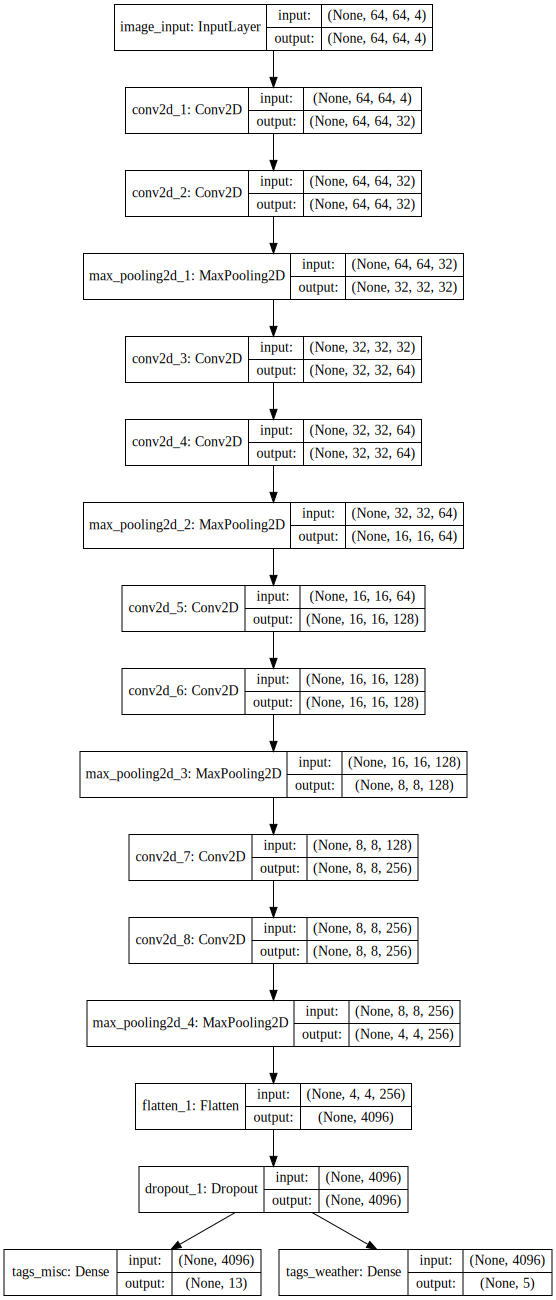

In [11]:
model_as_svg(model)

In [12]:
model.compile(
    optimizer='rmsprop',
    loss={
        'tags_misc': 'binary_crossentropy',
        'tags_weather': 'binary_crossentropy'
    },
    loss_weights={'tags_misc': 1.,
                  'tags_weather': 0.5})

In [13]:
def random_transform_batch(b):
    for i, img in enumerate(b[0]):
        b[0][i] = random_transform(img, debug=False)
    return b

In [14]:
# @see http://anandology.com/blog/using-iterators-and-generators/

import threading


class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))

    return g

In [39]:
# data generation

# train_batch_index = -1


def train_generator():
    #     global train_batch_index

    #     a = 'T' + str(int(np.random.rand() * 1000))
    #     fn = '/tmp/gen-' + a

    while True:

        train_batch_index = np.random.randint(
            TRAIN_SAMPLES_PER_EPOCH / TRAIN_BATCH_SIZE)

        #         with open(fn, 'w') as f:
        #             f.write(str(train_batch_index))

        b = generate_batch(
            n_samples=TRAIN_BATCH_SIZE,
            batch_index=train_batch_index,
            X_files=X_files_train,
            Y_tags_misc=Y_tags_misc_train,
            Y_tags_weather=Y_tags_weather_train,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

        b = random_transform_batch(b)

        yield b


# val_batch_index = -1


def val_generator():
    #     global val_batch_index

    while True:
        val_batch_index = np.random.randint(
            VAL_SAMPLES_PER_EPOCH / VAL_BATCH_SIZE)

        b = generate_batch(
            n_samples=VAL_BATCH_SIZE,
            batch_index=val_batch_index,
            X_files=X_files_val,
            Y_tags_misc=Y_tags_misc_val,
            Y_tags_weather=Y_tags_weather_val,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

        b = random_transform_batch(b)

        yield b

In [ ]:
model.fit_generator(
    train_generator(),
    steps_per_epoch=TRAIN_SAMPLES_PER_EPOCH,
    epochs=TRAIN_EPOCHS,
    verbose=1,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_DIR, histogram_freq=0),
        ModelCheckpoint(
                MODEL_CHECKPOINT_DIR + \
                '/e{epoch:02d}-l={loss:.5f}-vl={val_loss:.5f}.h5',
                monitor='val_loss', verbose=0, save_best_only=False,
                save_weights_only=False, mode='auto'
            ),
    ],
    validation_data=val_generator(),
    validation_steps=VAL_SAMPLES_PER_EPOCH,
    class_weight=None,
    max_q_size=40,
    workers=4,
    pickle_safe=True,
    initial_epoch=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=4, initial_epoch=0, epochs=100, callbacks=[<keras.ca..., steps_per_epoch=32383, validation_steps=8096, max_queue_size=40, validation_data=<generator..., verbose=1, class_weight=None)`
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1786: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 4519/32383 [===>..........................] - ETA: 602s - loss: 0.2670 - tags_misc_loss: 0.1738 - tags_weather_loss: 0.1864

---

In [ ]:
b = generate_batch(
            n_samples=10,
            batch_index=0,
            X_files=X_files_train,
            Y_tags_misc=Y_tags_misc_train,
            Y_tags_weather=Y_tags_weather_train,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

In [ ]:
b_ = random_transform_batch(b)
plt.imshow(b_[0][4][:,:,3])

Random shear applied 0.39269908169872414
Random shear applied 0.39269908169872414
Random shift applied (0.25, 0.25)
Random shear applied 0.39269908169872414
Random shift applied (0.25, 0.25)
Random zoom applied (0.75, 1.25)
Random shift applied (0.25, 0.25)
Random zoom applied (0.75, 1.25)
Random shear applied 0.39269908169872414
Random shear applied 0.39269908169872414
Random shift applied (0.25, 0.25)


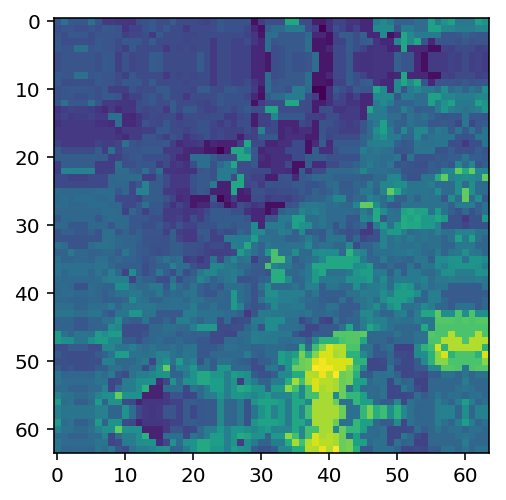

In [33]:
b_ = random_transform_batch(b)
plt.imshow(b_[0][4][:,:,3])

Random zoom applied (0.75, 1.25)
Random shift applied (0.25, 0.25)
Random shift applied (0.25, 0.25)
Random shift applied (0.25, 0.25)
Random zoom applied (0.75, 1.25)
Random rotation applied 45
Random rotation applied 45
Random shift applied (0.25, 0.25)
Random rotation applied 45
Random shear applied 0.39269908169872414
Random shift applied (0.25, 0.25)
Random zoom applied (0.75, 1.25)
Random rotation applied 45
Random zoom applied (0.75, 1.25)
Random zoom applied (0.75, 1.25)
Random shift applied (0.25, 0.25)


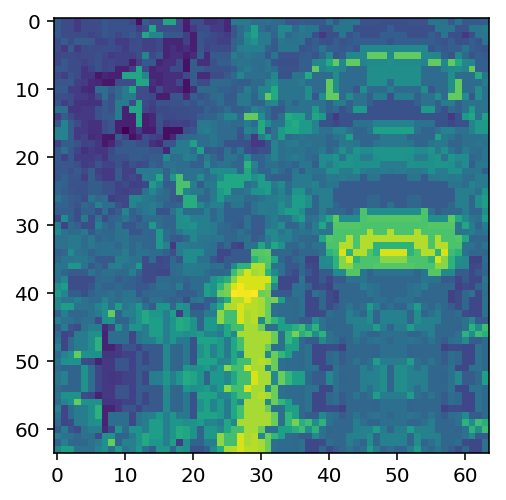

In [36]:
b_ = random_transform_batch(b)
plt.imshow(b_[0][4][:,:,3])